In [1]:
using FFTW
using SpecialFunctions
using LinearAlgebra
using Elliptic
using RowEchelon
using Plots
using JLD2
using FileIO
using DelimitedFiles
using UnicodePlots

In [11]:
function LinearStablityHP(filename,M,index,dN,outname)
    health = readdlm(filename)
    heal = health[index,:]
    health = nothing
    Nx = 2048
    L = real(heal[1])
    
    dmu = 2*pi/L/M
    a = -pi/L
    b = pi/L
    
    mew = collect(a:dmu:b)
    println(length(mew))
    c = real(heal[2])
    eta = heal[4:2*Nx+3]
    uuu = heal[2*Nx+4:4*Nx+3]
    
    etanew = eta[1:dN:4096]
    uuunew = uuu[1:dN:4096]
    Nx = div(Nx,dN)
    
    uno = ones(Float64,Nx)
    reals= [0.0+0.0im;0.0+0.0im]
    kaps = collect(1:Nx)
    k = ([0;kaps;-kaps[Nx:-1:1]])*2*pi/L
    ku = mew[1].+k
    Ker = tanh.(ku)
    invet = ifft(etanew)
    n0=invet[1]
    et = invet[2:Nx+1]
    invu = ifft(uuunew)
    u0= invu[1]
    u = invu[2:Nx+1]
    
    B = zeros(Complex{Float64},4*Nx+2,4*Nx+2)
    B[1:2*Nx+1,1:2*Nx+1] = QuartersFiller(u,0.0,Nx,u0,k)
    B[2*Nx+2:4*Nx+2,2*Nx+2:4*Nx+2] .= B[1:2*Nx+1,1:2*Nx+1]
    B[1:2*Nx+1,2*Nx+2:4*Nx+2] = QuartersFiller(et,0.0,Nx,n0,k)
    D = zeros(Complex{Float64},4*Nx+2,4*Nx+2)
    D[1:2*Nx+1,1:2*Nx+1] = QuartersFiller1(u,Nx,u0)
    D[2*Nx+2:4*Nx+2,2*Nx+2:4*Nx+2] .= D[1:2*Nx+1,1:2*Nx+1]
    D[1:2*Nx+1,2*Nx+2:4*Nx+2] = QuartersFiller1(et,Nx,n0)
    for j in 1:2*Nx+1
       B[j,j] += c*k[j]*1im
       B[j+2*Nx+1,j+2*Nx+1] += c*k[j]*1im
       B[j,j+2*Nx+1] += -1im*k[j]
       D[j,j] += c*1im
       D[j+2*Nx+1,j+2*Nx+1] += c*1im
       D[j,j+2*Nx+1] += -1im
    end
    
    Eigs = Eigenmaker(et,u,mew[1],Ker,c,B,D,Nx)

    for pp in 1:4*Nx+2
        if abs(real(Eigs[pp])) > 5*10^(-8)
            reals = [reals [mew[1]; Eigs[pp]]]
        end
    end    
    for ppp in 2:M+1
        println(ppp)
        ku = mew[ppp].+k
        Ker = tanh.(ku)
        Eigs = Eigenmaker(et,u,mew[ppp],Ker,c,B,D,Nx)
        for pp in 1:4*Nx+2
            if abs(real(Eigs[pp])) > 5*10^(-8)
                reals = [reals [mew[ppp]; Eigs[pp]]]
            end
        end
        if ppp % 50 == 0
           display(plot(real(reals[2,:]),imag(reals[2,:]),seriestype=:scatter))
        end 
    end
    display(plot(real(reals[1,:]),real(reals[2,:]),seriestype=:scatter))
    display(plot(real(reals[1,:]),imag(reals[2,:]),seriestype=:scatter))
    display(plot(real(reals[2,:]),imag(reals[2,:]),seriestype=:scatter))
    save(outname, Dict("hello" => reals))
end

LinearStablityHP (generic function with 2 methods)

In [4]:
function QuartersFiller(et,mu,Nx,avg,k)
    Quar = zeros(Complex{Float64},2*Nx+1,2*Nx+1)
    for j in 1:Nx
        Quar[1,j+1] = -et[j]*(1im*(mu))
        Quar[1,2*Nx+2-j] = -et[j]*(1im*(mu))
        Quar[j+1,1] = -et[j]*(1im*(mu+k[j+1]))
        Quar[2*Nx+2-j,1] = -et[j]*(1im*(mu-k[j+1]))
        for jj in 1:Nx
            if j != jj
                Quar[j+1,jj+1] = -et[abs(jj-j)]*(1im*(mu+k[j+1])) 
            end
        end
        for jj in 1:Nx-j
            Quar[j+1,2*Nx+2-jj] = -et[abs(j+jj)]*(1im*(mu+k[j+1]))
        end
    end
    for j in 1:Nx
        for jj in 1:Nx
            if j != jj
                Quar[2*Nx+2-j,2*Nx+2-jj] = -et[abs(j-jj)]*(1im*(mu-k[j+1]))
            end
        end
        for jj in 1:Nx-j
            Quar[2*Nx+2-j,jj+1] = -et[abs(j+jj)]*(1im*(mu-k[j+1]))
        end
    end
    for j in 1:Nx
        Quar[j+1,j+1] = -avg*k[j+1]*1im
        Quar[2*Nx+2-j,2*Nx+2-j] = avg*k[j+1]*1im
    end
    return Quar
end

QuartersFiller (generic function with 1 method)

In [5]:
function QuartersFiller1(et,Nx,avg)
    Quar = zeros(Complex{Float64},2*Nx+1,2*Nx+1)
    for j in 1:Nx
        Quar[1,j+1] = -et[j]*1im
        Quar[1,2*Nx+2-j] = -et[j]*1im
        Quar[j+1,1] = -et[j]*1im
        Quar[2*Nx+2-j,1] = -et[j]*1im
        for jj in 1:Nx
            if j != jj
                Quar[j+1,jj+1] = -et[abs(j-jj)]*1im
            end
        end
        for jj in 1:Nx-j
            Quar[j+1,2*Nx+2-jj] = -et[abs(j+jj)]*1im
        end
    end
    for j in 1:Nx
        for jj in 1:Nx
            if j != jj
                Quar[2*Nx+2-j,2*Nx+2-jj] = -et[abs(jj-j)]*1im
            end
        end
        for jj in 1:Nx-j
            Quar[2*Nx+2-j,jj+1] = -et[abs(j+jj)]*1im
        end
    end
    for j in 1:Nx
        Quar[j+1,j+1] = -avg*1im
        Quar[2*Nx+2-j,2*Nx+2-j] = -avg*1im
    end
    ###Remember to look at this Katie
    Quar[1,1]=-1im*avg
    return Quar
end

QuartersFiller1 (generic function with 1 method)

In [6]:
function Eigenmaker(et,u,mu,Ker,c,B,D,Nx)
    Jack = -1im*Ker
    Jimmy = D*mu
    for j in 1:2*Nx+1
        Jimmy[j+2*Nx+1,j] += Jack[j]
    end
    Jimmy += B
    ###display(UnicodePlots.spy(abs.(Jimmy))) to print out the spy of the dense matrix
    Eigs = eigvals(Jimmy)
    return Eigs
end

Eigenmaker (generic function with 1 method)

501
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


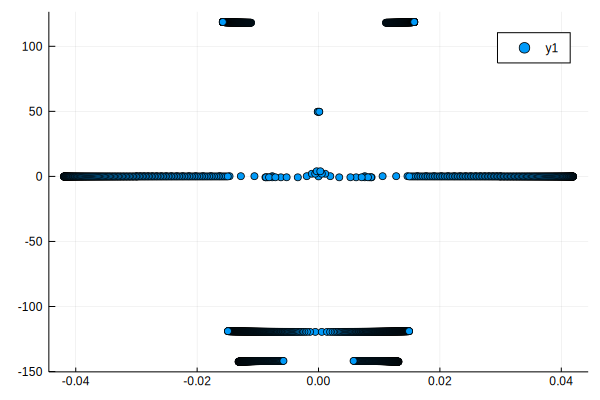

200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249

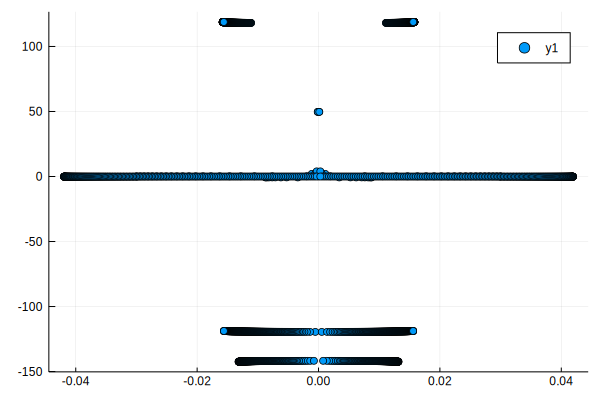


250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299


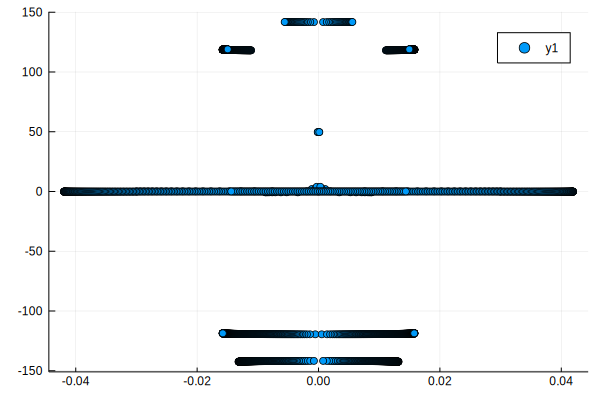

300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349


350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399


400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449


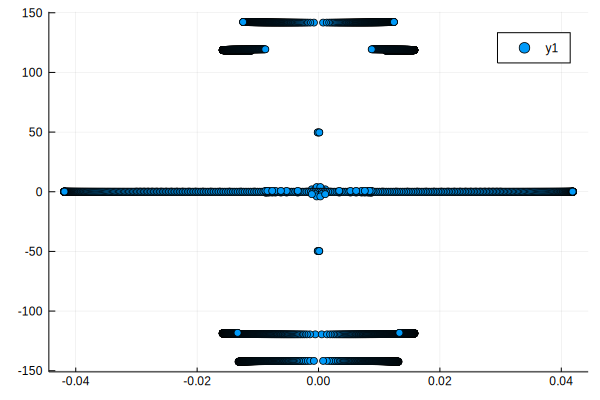

450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


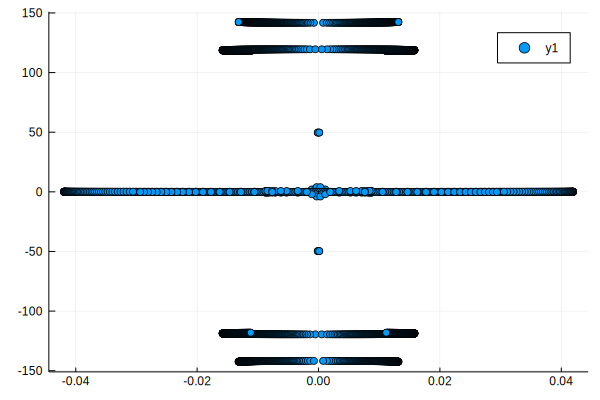

500


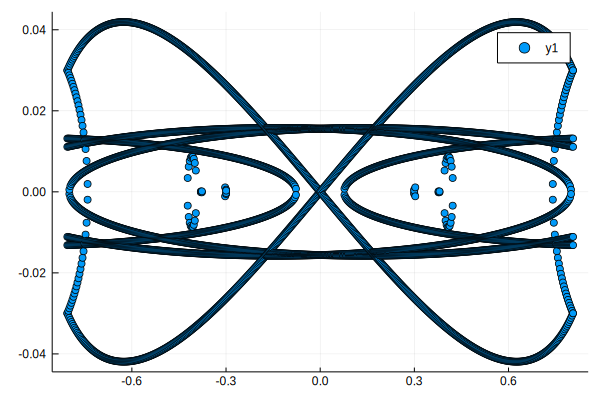

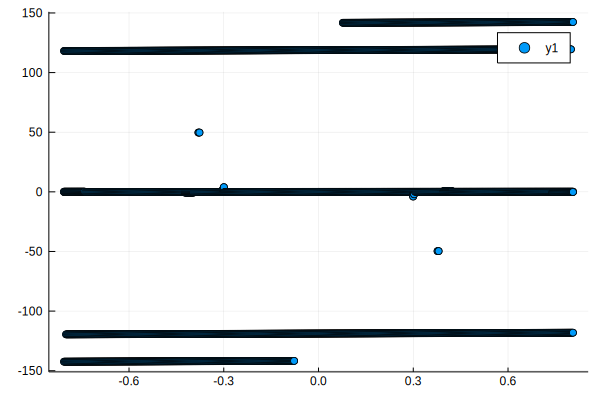

501


In [12]:
LinearStablityHP("NZMSolns390.out",500,40,16,"real40parta256.jld2")